In [27]:
import pandas as pd
dataset = pd.read_csv('data/NHL.csv', header=None)
dataset.columns = ['year', 'league', 'time', 'home_team', 'away_team', 'home_score', 'away_score', 'difference_score','result', 'country', 'home_shots', 'away_shots','home_hits','away_hits']
dataset = dataset.drop(columns = ['year', 'league', 'country'])
dataset.away_team.unique()
dataset.to_csv('data/NHL_with_headers.csv', index=False)

df = pd.read_csv('data/NHL_with_headers.csv')
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%y')



Epoch 1, Loss: 4.962006092071533
Epoch 2, Loss: 4.337645053863525
Epoch 3, Loss: 4.161351680755615
Epoch 4, Loss: 3.0918431282043457
Epoch 5, Loss: 3.0166945457458496
Epoch 6, Loss: 2.6225526332855225
Epoch 7, Loss: 2.011362314224243
Epoch 8, Loss: 1.855964183807373
Epoch 9, Loss: 1.7712132930755615
Epoch 10, Loss: 1.50192129611969
Epoch 11, Loss: 1.349860668182373
Epoch 12, Loss: 1.3059483766555786
Epoch 13, Loss: 1.1912384033203125
Epoch 14, Loss: 1.1521503925323486
Epoch 15, Loss: 1.1336616277694702
Epoch 16, Loss: 1.0912500619888306
Epoch 17, Loss: 1.0882285833358765
Epoch 18, Loss: 1.0828911066055298
Epoch 19, Loss: 1.07660710811615
Epoch 20, Loss: 1.0616663694381714
Epoch 21, Loss: 1.0712110996246338
Epoch 22, Loss: 1.068063735961914
Epoch 23, Loss: 1.0644915103912354
Epoch 24, Loss: 1.0820668935775757
Epoch 25, Loss: 1.0645034313201904
Epoch 26, Loss: 1.0664615631103516
Epoch 27, Loss: 1.0702685117721558
Epoch 28, Loss: 1.062282919883728
Epoch 29, Loss: 1.0531803369522095
Epoch 

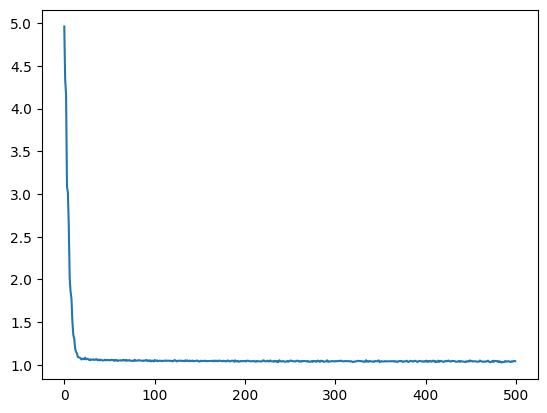

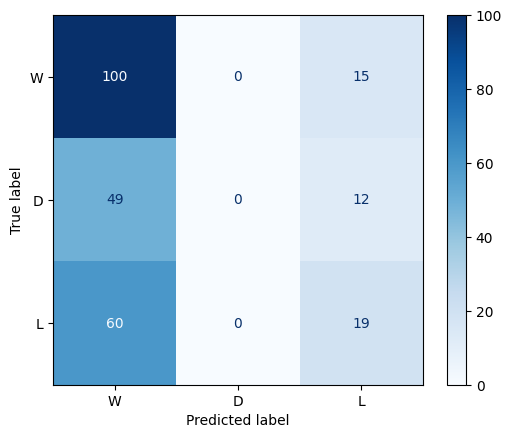

0.4666666666666667


In [45]:

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv('data/NHL_with_headers.csv')
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%y')
df = df.drop(columns=['home_score', 'away_score', 'difference_score'])

df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe


# Convert teams to integers
team_to_int = {team: i for i, team in enumerate(pd.concat([df['home_team'], df['away_team']]).unique())}
df['home_team'] = df['home_team'].map(team_to_int)
df['away_team'] = df['away_team'].map(team_to_int)

# Convert results to integers
result_map = {'W': 2, 'D': 1, 'L': 0}
df['result'] = df['result'].map(result_map)



# Split into training and test datasets (80%-20%)
train_df = df[:int(0.8 * len(df))]
test_df = df[int(0.8 * len(df)):]

# Function to create Data instance from dataframe
def create_data_from_df(df):
    edge_index = torch.tensor(df[['home_team', 'away_team']].values).t().contiguous()
    x = torch.tensor(df[['home_shots', 'away_shots', 'home_hits', 'away_hits']].values, dtype=torch.float)
    #x = torch.tensor(df[['home_score', 'away_score', 'difference_score', 'home_shots', 'away_shots', 'home_hits', 'away_hits']].values, dtype=torch.float)
    y = torch.tensor(df['result'].values)
    return Data(x=x, edge_index=edge_index, y=y)

train_data = create_data_from_df(train_df)
test_data = create_data_from_df(test_df)


# GNN Model
class GNN_new(torch.nn.Module):
    def __init__(self, input_dim):
        super(GNN_new, self).__init__()
        self.conv1 = GCNConv(input_dim, 128)
        self.conv2 = GCNConv(128, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GNN_new(train_data.x.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training
def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.nll_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()


losses = []
for epoch in range(500):
    loss = train()
    losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')
pd.Series(losses).plot()
#savefig('loss_gnn_norm.png')
#fig2 = plt.gcf()
#fig2.savefig('loss_gnn_norm.png')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    test_out = model(test_data)
    _, predicted_test = test_out.max(dim=1)

# Actual results
y_true = test_data.y.numpy()

# Predictions
y_pred = predicted_test.numpy()

# Create the confusion matrix
cm = confusion_matrix(test_data.y, predicted_test, labels=[2, 1, 0])  # Assuming labels are 2 for "W", 1 for "D", and 2 for "L"

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "D", "L"])
disp.plot(cmap='Blues')
#fig1 = plt.gcf()
plt.show()
#fig1.savefig('cm_gnn_norm.png')

score = accuracy_score(y_true, y_pred)
print(score)

In [5]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 53.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 56.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 26.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 14.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━

In [6]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=b7bd986f9f9025f61fbaf193f7390508aba0d83c2cd290f322b320576513cae2
  Stored in directory: /home/jupyter/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [47]:
# Conv GNN network
import torch
from torch.nn import LogSoftmax, ReLU, Tanh, LeakyReLU, ModuleList, Dropout
from torch_geometric.nn import GCNConv, GraphConv, ChebConv

target_dim = 3

activations = {
    'relu': ReLU(),
    'tanh': Tanh(),
    'leaky': LeakyReLU()
}


class GNNModel_from_paper(torch.nn.Module):
    def __init__(self, num_teams, embed_dim=10, n_conv=3, conv_dims=(32, 32, 32, 16), n_dense=5, dense_dims=(8, 8, 8, 8,8),
                 act_f='leaky', **kwargs):
        super(GNNModel_from_paper, self).__init__()
        self.embed_dim = embed_dim
        self.n_conv = n_conv
        self.conv_dims = conv_dims
        self.n_dense = n_dense
        self.activation = activations[act_f]
        self.num_teams = num_teams

        self.embedding = torch.nn.Embedding(num_embeddings=num_teams, embedding_dim=embed_dim)

        conv_layers = [GraphConv(self.embed_dim, self.conv_dims[0])]
        for i in range(n_conv - 1):
            conv_layers.append(GraphConv(conv_dims[i], conv_dims[i + 1]))
        self.conv_layers = ModuleList(conv_layers)

        lin_layers = []
        lin_layers.append(torch.nn.Linear(conv_dims[n_conv - 1]*2, dense_dims[0]))
        for i in range(n_dense - 2):
            lin_layers.append(torch.nn.Linear(dense_dims[i], dense_dims[i + 1]))
        lin_layers.append(torch.nn.Linear(dense_dims[n_dense - 2], target_dim))

        self.lin_layers = ModuleList(lin_layers)

        self.out = LogSoftmax(dim=1)
        self.drop = Dropout(p=0.1)


    def forward(self, data, home, away):
        edge_index, edge_weight = data.edge_index, data.edge_weight
        if hasattr(self, 'num_teams'):
            num_teams = self.num_teams
        else:
            num_teams = data.n_teams
        x = torch.tensor(list(range(num_teams)))
        x = self.embedding(x).reshape(-1, self.embed_dim)

        if len(edge_weight) > 0:
            x = self.conv_layers[0](x, edge_index, edge_weight )
        else:
            x = self.conv_layers[0](x, edge_index)
        x = self.activation(x)
        x = self.drop(x)

        for i in range(self.n_conv - 1):
            if len(edge_weight) > 0:
                    x = self.activation(self.conv_layers[i + 1](x, data.edge_index, edge_weight))
            else:
                x = self.activation(self.conv_layers[i + 1](x, data.edge_index))
            # x = self.drop(x)

        x = torch.cat([x[home], x[away]], dim=1)
        # x = torch.sub(x[home], x[away])

        for i in range(self.n_dense):
            x = self.activation(self.lin_layers[i](x))
            x = self.drop(x)

        x = self.out(x)
        return x.reshape(-1, target_dim)
    
    


In [48]:
import torch
from torch.nn import Embedding, Linear, Dropout, ModuleList
from torch.nn import LogSoftmax, ReLU, Tanh, LeakyReLU

activations = {
    'relu': ReLU(),
    'tanh': Tanh(),
    'leaky': LeakyReLU(0.2)
}


class FlatModel(torch.nn.Module):
    def __init__(self, n_teams, out_dim=3, embed_dim=10, pretrained_weights=None, n_dense=4, dense_dims=(4,4,4,32),
                 act_f='leaky', **kwargs):
        super(FlatModel, self).__init__()
        # set hyperparameters for the model
        self.n_teams = n_teams
        self.out_dim = out_dim
        self.activation = activations[act_f]
        self.n_dense = n_dense

        # set the layers to be used in the model
        if pretrained_weights is not None:
            self.embedding = Embedding.from_pretrained(pretrained_weights)
        else:
            self.embedding = Embedding(n_teams, embed_dim)

        lin_layers = []
        lin_layers.append(torch.nn.Linear(embed_dim * 2, dense_dims[0]))
        for i in range(n_dense - 2):
            lin_layers.append(torch.nn.Linear(dense_dims[i], dense_dims[i + 1]))
        lin_layers.append(torch.nn.Linear(dense_dims[n_dense - 2], self.out_dim))
        self.lin_layers = ModuleList(lin_layers)

        self.out = LogSoftmax(dim=1)

        self.drop = Dropout(p=0.1)

    def forward(self, data, team_home, team_away):
        home_emb = self.embedding(team_home)
        away_emb = self.embedding(team_away)
        x = torch.cat((home_emb, away_emb), 1)

        for layer in self.lin_layers:
            x = self.activation(layer(x))
            x = self.drop(x)

        x = self.out(x)
        return x.reshape(-1, self.out_dim)

In [49]:
import numpy as np
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import math
import torch.nn as nn
import torch.optim as optim
from typing import Tuple
import pickle
from itertools import permutations
import numpy.ma as ma


input_filename = "data/NHL.csv"
model_name = "GNNModel_from_paper"

#dataset = pd.read_csv('data/NHL.csv', header=None)
#dataset.columns = ['year', 'league', 'time', 'home_team', 'away_team', 'home_score', 'away_score', 'difference_score','result', 'country', 'home_shots', 'away_shots','home_hits','away_hits']
names = ['year', 'league', 'time', 'home_team', 'away_team', 'home_score', 'away_score', 'difference_score','result', 'country', 'home_shots', 'away_shots','home_hits','away_hits']

#num_teams = len(pd.concat([dataset['home_team'], dataset['away_team']]).unique())
#model = GNNModel_from_paper(num_teams=num_teams)


class DataTransformer:
    def __init__(self, filename: str):
        self.label_encoder = LabelEncoder()
        self.filename = filename
        self.data = None
        self.data_train = None
        self.data_val = None
        self.data_test = None
        self.n_teams = None

        self.read_data()
        self.data = self.clean_data(self.data)
        self.N = self.data.shape[0]
        self.fit_encoder()
        # self.prepare_data()

    def read_data(self):
        """Read the data from csv with correct data types."""
        #dataset = pd.read_csv('data/NHL.csv', header=None)
        self.data = pd.read_csv(self.filename, header=None, names=names,
                                dtype=dict(zip(names, [int] + [str] * 4 + [int] * 3 + [str] * 2 + [int]*4)))

    def clean_data(self,data, convert_to_numpy=False, allow_draw=True) :
        """Add a column to transform result of the match into int, """
        # result ot int
        conditions = [
            (data['result'] == 'W'),
            (data['result'] == 'D'),
            (data['result'] == 'L')]
        choices = [2,1,0]
        data['lwd'] = np.select(conditions, choices)
        if names[-1] != 'lwd':
            names.append('lwd')
        # ignore the draw results
        if not allow_draw:
            data = self.data[self.data['result'] != 'D']
        if convert_to_numpy:
            data = self.data.to_numpy()
        return data

    def fit_encoder(self):
        data = self.data
        data = data.to_numpy()
        teams = np.unique(data[:, [3, 4]])
        self.n_teams = len(teams)
        X = data[:, [3, 4]]
        X = X.flatten()
        self.label_encoder.fit(X)

    def encode_teams(self, data):
        data = data.to_numpy()
        teams = np.unique(data[:, [3, 4]])
        # self.n_teams = len(teams)
        X = data[:, [3, 4]]

        X = X.flatten()
        X = self.label_encoder.transform(X)
        teams_encoded = self.label_encoder.transform(teams)
        teams_encoded = pd.DataFrame({'teams': teams, 'label_encoding': teams_encoded})

        data[:, [3, 4]] = np.reshape(X, (-1, 2))
        return data, teams_encoded


    def prepare_data(self, data=None, split_to_test=True, save_to_self=False):
        if data is None:
            data = self.data

        data, teams_encoded = self.encode_teams(data)

        if split_to_test:
            separator_val = int(data.__len__() * 0.8)
            separator_test = int(data.__len__() * 0.9)
            # separator_test_final = int(int(data.__len__() * 0.9))
            data_train = pd.DataFrame(data=data[:separator_val], columns=names)
            data_val = pd.DataFrame(data=data[separator_val:separator_test], columns=names)
            data_test = pd.DataFrame(data=data[separator_test:], columns=names)
            data_test_final = []
            # data_test_final = pd.DataFrame(data=data[separator_test_final:], columns=names)
            self.print_metadata(data_train, "train")
            self.print_metadata(data_val, "val")
            self.print_metadata(data_test, "test")
            if save_to_self:
                self.data_train = data_train
                self.data_val = data_val
                self.data_test = data_test
            self.N = data.shape[0]
            return data_train, data_val, data_test, data_test_final, teams_encoded
        else:
            data = pd.DataFrame(data=data, columns=names)
            if save_to_self:
                self.data = data
            return self.data, teams_encoded

    def to_tensor(self,data):
        home = torch.tensor(data['home_team'].values.astype(int)).to(torch.int64)
        away = torch.tensor(data['away_team'].values.astype(int)).to(torch.int64)
        label = data['lwd'].values.astype(int).reshape(-1,1)
        # self.ohe = OneHotEncoder()
        # self.ohe.fit(label)
        # label = self.ohe.transform(label).toarray()

        label = torch.tensor(label).to(torch.int64)
        return home, away, label

    def get_train_data(self):
        self.print_metadata(self.data_train, "Information on Train data: ")
        home, away, label = self.to_tensor(self.data_train)
        return home, away, label

    def get_test_data(self):
        self.print_metadata(self.data_test, "Information on Test data: ")
        home, away, label = self.to_tensor(self.data_test)
        return home, away, label

    @staticmethod
    def print_metadata(data, message=""):
        # print some metadata
        won = data[data['result'] == "W"].shape[0]
        lost = data[data['result'] == "L"].shape[0]
        draw = data[data['result'] == "D"].shape[0]
        total = data.shape[0]
        # print("Won:", won, won / total * 100, ", Lost:", lost, lost / total * 100)
        print("Total {} data points: {}, Won: {}%, Lost: {}%, Draw: {}%".format(message, total, won*100 / total, lost*100 / total, draw*100 / total))
        # print("The number of data points in the data set is:", total)
		

class Dataset:
    def __init__(self, filename):
        self.filename = filename

    def process(self):
        data_list = []

        dt = DataTransformer(self.filename)
        grouped = dt.data.groupby(['league'])
        for league_year, group in tqdm(grouped):
            data_train, data_val, data_test, data_test_final, teams_enc = dt.prepare_data(data=group)
            n_teams = len(teams_enc['teams'].values)
            win_lose_network = np.zeros((dt.n_teams, 2, dt.n_teams))
            x = torch.ones(dt.n_teams).reshape(-1, 1)

            edge_time = np.empty((dt.n_teams, dt.n_teams))
            edge_time[:] = None

            node_time = np.zeros(dt.n_teams)

            won = data_test[data_test['result'] == "W"].shape[0]
            lost = data_test[data_test['result'] == "L"].shape[0]
            draw = data_test[data_test['result'] == "D"].shape[0]

            data = Data(
                edge_index=torch.tensor([]).reshape(2,-1).long(),
                edge_weight=torch.tensor([]),
                matches=data_train,
                n_teams=n_teams,
                win_lose_network=win_lose_network,
                node_time=node_time,
                node_weight=None,
                edge_time=edge_time,
                data_val=data_val,
                data_test=data_test,
                data_test_final=data_test_final,
                curr_time=0,
                N=dt.N,
                baseline=max(won, lost, draw),
                train_loss=[],
                train_accuracy=[],
                val_loss=[],
                val_accuracy=[],
                teams_enc=teams_enc
            )
            data_list.append(data)

        return data_list
		
def update_edge_index(data):
    """
    Update the edge indeces
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :return:
    """
    data.edge_index = torch.tensor(np.where(~np.isnan(data.edge_time)))


def update_edge_time(data, home, away, result):
    """
    Updating the time of the recent matches between the teams
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param home: the label encoded names of the home teams
    :param away: the label encoded names of the away teams
    :param result: the outcomes of the matches
    :return:
    """
    winning_team = np.array([]).astype('int64')
    losing_team = np.array([]).astype('int64')

    # home won
    winning_team = np.append(winning_team, home[np.where(result == 2)[0]])
    losing_team = np.append(losing_team, away[np.where(result == 2)[0]])
    # away won
    winning_team = np.append(winning_team, away[np.where(result == 0)[0]])
    losing_team = np.append(losing_team, home[np.where(result == 0)[0]])
    # draw
    winning_team = np.append(winning_team, home[np.where(result == 1)[0]])
    winning_team = np.append(winning_team, away[np.where(result == 1)[0]])
    losing_team = np.append(losing_team, away[np.where(result == 1)[0]])
    losing_team = np.append(losing_team, home[np.where(result == 1)[0]])

    data.edge_time[losing_team, winning_team] = int(data.curr_time)


def calculate_edge_weight(data, time_weighing="linear"):
    """
    Compute the edge weight based on the recency of the last match between the teams
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param time_weighing: the type of weighing: linear or exponential
    :return:
    """
    if len(data.edge_index) > 0:
        from_nodes = data.edge_index[0].numpy()
        to_nodes = data.edge_index[1].numpy()

        prev_edge_time = data.edge_time[from_nodes, to_nodes]
        prev_edge_time[np.isnan(prev_edge_time)] = int(data.curr_time)

        if time_weighing == "linear":
            data.edge_weight = torch.tensor(1 - ((int(data.curr_time) - prev_edge_time) / data.N)).reshape(-1, ).float()
        elif time_weighing == "exponential":
            data.edge_weight = torch.tensor(np.exp( - int(data.curr_time) - prev_edge_time)).reshape(-1, ).float()
    else:
        data.edge_weight = torch.tensor([])




log_base = 1.5
val_batches = 72
target_dim = 3




def continuous_evaluation(data: Data, model, epochs=100, lr=0.001, lr_discount=0.2, batch_size=9, mode="val"):
    """
    A gateway function for starting the training, validation and testing of the provided model using continuous
    evaluation
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param model: the model
    :param epochs: the number of epochs
    :param lr: the learning rate
    :param lr_discount: the learning rate discount if the adaptable learning rate is used
    :param batch_size: size of batches in which the model is trained
    :param mode: mode in which the function is used: "val" for validation, "test" for testing
    :return:
    """
    print("Continuous evaluation")
    train_function = train_cont
    test_function = test_cont

    if mode == "val":
        print(f"matches:{data.matches}")
        print(f"data_val:{data.data_val}")
       # matches = data.matches.append(data.data_val, ignore_index=True)
        matches = pd.concat([data.matches,data.data_val])
    else:
        matches = data.data_test
        test_acc = []
        global val_batches
        val_batches = 1

    for i in range(0, matches.shape[0], batch_size):
        test_function(data, model, matches.iloc[i:i + val_batches * batch_size])
        train_start_point = max(0, i - 40 * batch_size)
        data.curr_time = train_start_point
        train_function(data,model,
                       # matches.head(i + batch_size),
                       matches.iloc[train_start_point:i + batch_size],
                       # epochs,
                       epochs + int(math.log(i + 1, log_base)),
                       # lr * (1 - lr_discount) ** int(i / batch_size / 50),
                       lr,
                       batch_size)
        print("T:{}, train_loss:{:.5f}, train_acc:{:.5f}, val_loss={:.5f}, val_acc={:.5f}"
              .format(int(i / batch_size),
                      data.train_loss[-1],
                      data.train_accuracy[-1],
                      data.val_loss[-1],
                      data.val_accuracy[-1]))
        if mode == "test":
            test_acc.append(data.val_accuracy[-1])

    val_acc = data.val_accuracy[len(data.val_accuracy) - val_batches:]
    data.val_acc = sum(val_acc) / len(val_acc)

    if mode == "test":
        print(sum(test_acc) / len(test_acc))
    else:
        print(data.val_acc)


def train_cont(data: Data, model: torch.nn.Module, matches,
               epochs:int = 100, lr: int = 0.0001, batch_size:int = 9, print_info: bool = False):
    """
    A function for training the provided model with the provided matches using continuous evaluation
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param model: the model
    :param matches: the data set
    :param epochs: the number of epochs
    :param lr: the learning rate
    :param batch_size: size of batches in which the model is trained
    :param print_info: a binary flag that indicates if the information about the training should be printed out to the
        terminal
    :return:
    """
    criterion = nn.NLLLoss()  # weight=torch.tensor([1.6,1.95,1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    running_loss = []
    running_accuracy = []
    home_win = 0
    for epoch in range(epochs):
        acc = 0
        loss_value = 0.0
        optimizer.zero_grad()
        for j in range(0, matches.shape[0], batch_size):
            home, away, result = torch.from_numpy(matches.iloc[j:j + batch_size]['home_team'].values.astype('int64')), \
                                 torch.from_numpy(matches.iloc[j:j + batch_size]['away_team'].values.astype('int64')), \
                                 torch.from_numpy(
                                     matches.iloc[j:j + batch_size]['lwd'].values.astype('int64').reshape(-1, ))
            home_win += (result == 2).sum().item()
            # label = torch.zeros(result.shape[0], target_dim).scatter_(1, torch.tensor(result), 1)  # one-hot label for loss
            outputs = model(data, home, away)
            # loss = criterion(outputs, label.to(torch.float))
            loss = criterion(outputs, result)
            loss.backward()
            optimizer.step()
            loss_value += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct = int((predicted == result).sum().item())
            running_accuracy.append(correct)
            acc += correct

            update_edge_time(data, home, away, result)
            update_edge_index(data)
            calculate_edge_weight(data)
            data.curr_time += 1

        if print_info:
            print("Epoch:{}, train_loss:{:.5f}, train_acc:{:.5f}"
                  .format(epoch, loss_value, acc / (matches.shape[0])))

        data.curr_time -= math.ceil(matches.shape[0] / batch_size)  # probably is safe to be set to 0 each epoch
        running_loss.append(loss_value)
        # if epoch % 50 == 49:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] *= 0.8
    # print(home_win/(matches.shape[0] * epochs))
    data.train_loss.append(sum(running_loss) / ((matches.shape[0] / batch_size) * epochs))
    data.train_accuracy.append(sum(running_accuracy) / (matches.shape[0] * epochs))


def test_cont(data: Data, model: torch.nn.Module, matches, mode: str = "val"):
    """
    A function for testing the provided model on the provided matches using continuous evaluation
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param model: the model
    :param matches: the data set
    :param mode: mode in which the testing function is used: "val" for validation, "test" for testing
    :return:
    """
    criterion = nn.NLLLoss()  # weight=torch.tensor([1.6,1.95,1])

    predicted, label, outputs = get_predictions(data, model, matches)

    loss = criterion(outputs, label).item()

    correct = int((predicted == label).sum().item())
    if mode == "test":
        data.test_accuracy = float(correct) / matches.shape[0]
    else:
        data.val_accuracy.append(float(correct) / matches.shape[0])
        data.val_loss.append(loss)
        
        
def get_predictions(data: Data, model: torch.nn.Module, matches) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Compute the predictions for the provided matches using provided model
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param model: the model
    :param matches: the data set
    :return: Tensors of predictions for each match, a ground truth label and the probabilities
    """
    outputs, label = get_probabilities(data, model, matches)
    _, predicted = torch.max(torch.exp(outputs.data), 1)
    return predicted, label, outputs


def get_probabilities(data, model, matches):
    model.eval()
    home, away, label = torch.from_numpy(matches['home_team'].values.astype('int64')), \
                        torch.from_numpy(matches['away_team'].values.astype('int64')), \
                        torch.from_numpy(matches['lwd'].values.astype('int64').reshape(-1, ))
    with torch.no_grad():
        outputs = model(data, home, away)
    model.train()
    return outputs, label


def get_rps(data: Data, model: torch.nn.Module, matches) -> float:
    """
    Computation of PRS score for a provided model on provided data
    :param data: a Dataset instance associated with the model that contains the necessary data for training and the
        metadata
    :param model: the model
    :param matches: the data set
    :return:
    """
    outputs, label = get_probabilities(data, model, matches)
    _, predicted = torch.max(outputs.data, 1)
    o_h_label = torch.zeros(label.shape[0], target_dim).scatter_(1, label.reshape(-1, 1), 1)  # one-hot label for loss
    outputs = torch.exp(outputs)
    sub = torch.zeros((label.shape[0]))
    for i in range(target_dim):
        sub += torch.pow(torch.sum(outputs[:, :i + 1], 1) - torch.sum(o_h_label[:, :i + 1], 1), 2)
    rps = sub / (target_dim - 1)
    return rps

In [50]:
filename='./data/NHL.csv'
dataset = Dataset(filename=filename)
data_list = dataset.process() # load and process all the data

100%|██████████| 1/1 [00:00<00:00, 84.62it/s]

Total train data points: 1016, Won: 42.81496062992126%, Lost: 33.36614173228347%, Draw: 23.818897637795274%
Total val data points: 127, Won: 42.51968503937008%, Lost: 37.00787401574803%, Draw: 20.47244094488189%
Total test data points: 128, Won: 46.09375%, Lost: 32.03125%, Draw: 21.875%


In [53]:
def run_gnn_cont(data_list, dir_prefix="../", lr=0.0001, exp_num=0, **kwargs):
    """
    Training a GNN model using continuous evaluation. The model is then saved into pickle.
    :param filename: the name of the file with the input data
    :param dir_prefix: directory prefix for model saving
    :param lr: a learning rate for training
    :param exp_num: experiment number
    :param kwargs: additional parameters for the model
    :return:
    """

    epochs = [30] # number of initial epochs
    test_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    n_all_teams = 0
    for data in data_list:
        n_all_teams += data.n_teams
    model = GNNModel_from_paper(n_all_teams, **kwargs)

    for i, data in enumerate(data_list):
        print("GNN model, data {}", i)
        continuous_evaluation(data, model, epochs[0],lr=lr, batch_size=9)
        test_cont(data, model, data.data_test, "test")
        print("accuracy on testing data is: {}".format(data.test_accuracy))
        rps = get_rps(data, model, data.data_test)
        print("rps is below")
        print(torch.mean(rps).item())
        #print("accuracy on validation data is: {}".format(data.val_accuracy))
        #file = outfile.format(pickle_dir.format(dir_prefix), i, exp_num, "pickle")
        data_to_save = {"data": data, "model": model, "epochs": epochs}
        #save_to_pickle(file, data_to_save)
        test_acc.append(data.test_accuracy)
        val_acc.append(data.val_acc)
        train_loss.append(data.train_loss)
        val_loss.append(data.val_loss)
    
    test_accuracy = sum(test_acc) / len(test_acc)
    val_accuracy = sum(val_acc) / len(val_acc)
    #file = outfile.format(pickle_dir.format(dir_prefix), "all", exp_num, "pickle")
    #data_to_save = {"test_acc": test_acc, "val_acc": val_acc}
    #save_to_pickle(file, data_to_save)
    return test_accuracy, val_accuracy,model, dataset

test_acc, val_acc, model,dataset = run_gnn_cont(data_list)

GNN model, data {} 0
Continuous evaluation
matches:      year league      time home_team away_team home_score away_score  \
0     2017    NHL  04-10-17        30        26          2          7   
1     2017    NHL  05-10-17        10        14          4          2   
2     2017    NHL  05-10-17        20        29          4          4   
3     2017    NHL  05-10-17         2        16          4          3   
4     2017    NHL  05-10-17         3        15          2          2   
...    ...    ...       ...       ...       ...        ...        ...   
1011  2017    NHL  05-03-18         5        30          2          3   
1012  2017    NHL  05-03-18        14        10          4          1   
1013  2017    NHL  06-03-18        27        18          3          3   
1014  2017    NHL  06-03-18        11         1          3          3   
1015  2017    NHL  06-03-18         9        20          2          2   

     difference_score result country home_shots away_shots home_hits  \


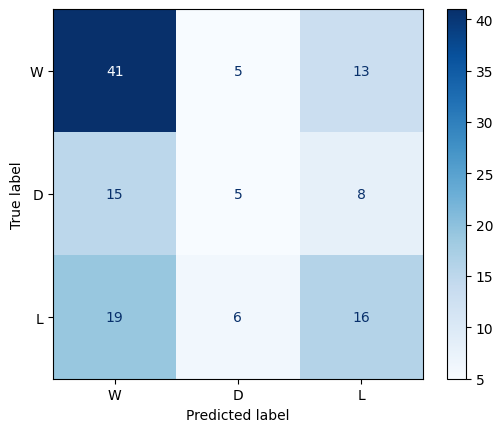

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

for data in data_list:
    y_pred, y_true, prob = get_predictions(data, model, data.data_test)
    y_pred, y_true = y_pred.numpy().astype('int'), y_true.numpy().astype('int')        
    cm = confusion_matrix(y_true, y_pred, labels=[2, 1, 0])  # Assuming labels are 2 for "W", 1 for "D", and 2 for "L"

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "D", "L"])
    disp.plot(cmap='Blues')
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig('cm_gnn.png')

In [25]:
def run_flat_cont(filename, dir_prefix="../", lr=0.00001, exp_num=0, **kwargs):
    """
    Training a Simple ANN model with embedding using continuous evaluation. The model is then saved into pickle.
    :param filename: the name of the file with the input data
    :param dir_prefix: directory prefix for model saving
    :param lr: a learning rate for training
    :param exp_num: experiment number
    :param kwargs: additional parameters for the model
    :return:
    """
    epochs = [30]  # number of initial epochs
    test_acc = []
    val_acc = []
    n_all_teams = 0
    for data in data_list:
        n_all_teams += data.n_teams
    model = FlatModel(n_all_teams, **kwargs)

    for i, data in enumerate(data_list):
        print("Flat model, data {}", i)
        continuous_evaluation(data, model, epochs[0],lr=lr, batch_size=9)
        test_cont(data, model, data.data_test, "test")
        print("accuracy on testing data is: {}".format(data.test_accuracy))
        rps = get_rps(data, model, data.data_test)
        print("rps is below")
        #file = outfile.format(pickle_dir.format(dir_prefix), i, exp_num, "pickle")
        #data_to_save = {"data": data, "model": model, "epochs": epochs}
        #save_to_pickle(file, data_to_save)
        test_acc.append(data.test_accuracy)
        val_acc.append(data.val_acc)

    test_accuracy = sum(test_acc)/len(test_acc)
    val_accuracy = sum(val_acc)/len(val_acc)
    #file = outfile.format(pickle_dir.format(dir_prefix), "all", exp_num, "pickle")
    #data_to_save = {"test_acc":test_acc, "val_acc":val_acc}
    #save_to_pickle(file, data_to_save)
    return test_accuracy, val_accuracy,model, dataset

test_acc, val_acc, model,dataset = run_flat_cont(data_list)


Flat model, data {} 0
Continuous evaluation
matches:      year league      time home_team away_team home_score away_score  \
0     2017    NHL  04-10-17        30        26          2          7   
1     2017    NHL  05-10-17        10        14          4          2   
2     2017    NHL  05-10-17        20        29          4          4   
3     2017    NHL  05-10-17         2        16          4          3   
4     2017    NHL  05-10-17         3        15          2          2   
...    ...    ...       ...       ...       ...        ...        ...   
1011  2017    NHL  05-03-18         5        30          2          3   
1012  2017    NHL  05-03-18        14        10          4          1   
1013  2017    NHL  06-03-18        27        18          3          3   
1014  2017    NHL  06-03-18        11         1          3          3   
1015  2017    NHL  06-03-18         9        20          2          2   

     difference_score result country home_shots away_shots home_hits  \

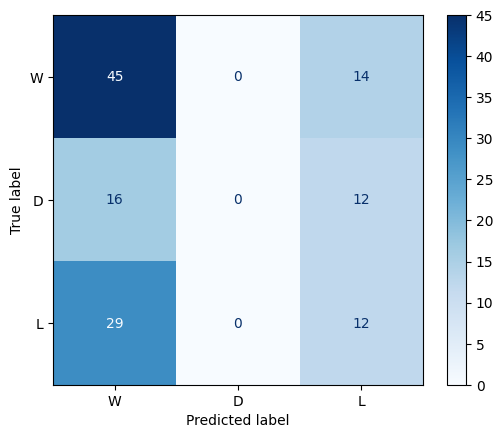

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

for data in data_list:
    y_pred, y_true, prob = get_predictions(data, model, data.data_test)
    y_pred, y_true = y_pred.numpy().astype('int'), y_true.numpy().astype('int')        
    cm = confusion_matrix(y_true, y_pred, labels=[2, 1, 0])  # Assuming labels are 2 for "W", 1 for "D", and 2 for "L"

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "D", "L"])
    disp.plot(cmap='Blues')
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig('cm_ann.png')